In [1]:
from sahi.slicing import slice_image
from sahi.utils.cv import read_image
from sahi.predict import get_prediction, get_sliced_prediction, predict
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import torch

from IPython.display import Image
import sys

sys.path.append("../../modules/yolov5")
sys.path.append("../")
from reef.plot import stack_images, plot_sample, plot_stack
from models.common import DetectMultiBackend
from utils.datasets import LoadImages, preprocess_image

%load_ext autoreload
%autoreload 2

## Dataset

In [302]:
from PIL import Image, ImageDraw
from reef.ops import yolo2coco

def plot_image(img, labels):
    color = (255, 0, 0)
    img_np = img.numpy().astype("uint8").transpose([1, 2, 0])
    img_height, img_width = img_np.shape[:2]
    with Image.fromarray(img_np) as im:
        draw = ImageDraw.Draw(im)
        for label in labels:
            label_yolo = yolo2coco(img_height, img_width, label)
            x, y, width, height = label_yolo
            print(label_yolo)
            draw.line((x, y, x+width, y), fill=color, width=2)
            draw.line((x+width, y, x+width, y+height), fill=color, width=2)
            draw.line((x+width, y+height, x, y+height), fill=color, width=2)
            draw.line((x, y+height, x, y), fill=color, width=2)

    return im

In [2]:
import yaml

with open("../../data/splits/s50/data.yaml") as f:
    data = yaml.load(f, yaml.Loader)
    
data

{'names': ['starfish'],
 'nc': 1,
 'train': '/home/isabella/code/competitions/great_barrier_reef/data/splits/s50/train.txt',
 'val': '/home/isabella/code/competitions/great_barrier_reef/data/splits/s50/valid.txt'}

In [429]:
from torch.utils.data import DataLoader
from reef.yolo.data import LoadImagesAndLabels


dataset = LoadImagesAndLabels(
    path=data['train'],
    slice_height=360,
    slice_width=640,
    img_size=640,
    batch_size=4,
    augment=False,
    stride=32,
    random_state=2,
    prefix='train: ',
    debug=True
)
# next(iter(dataset))
dataloader = DataLoader(dataset, 4, shuffle=True, num_workers=4, sampler=None, pin_memory=True, collate_fn=LoadImagesAndLabels.collate_fn)
for imgs, labels, paths, boxes in dataloader:
    print(imgs.size())
    print(labels)
    print(paths)
    print(boxes)
    break

torch.Size([4, 3, 384, 640])
tensor([[0.00000, 0.00000, 0.43437, 0.57292, 0.05469, 0.07812],
        [0.00000, 0.00000, 0.61563, 0.08594, 0.05937, 0.09115],
        [1.00000, 0.00000, 0.19219, 0.19531, 0.06094, 0.09896]])
('/home/isabella/code/competitions/great_barrier_reef/data/splits/s50/images/train/1-5429.jpg', '/home/isabella/code/competitions/great_barrier_reef/data/splits/s50/images/train/1-8815.jpg', '/home/isabella/code/competitions/great_barrier_reef/data/splits/s50/images/train/0-8236.jpg', '/home/isabella/code/competitions/great_barrier_reef/data/splits/s50/images/train/1-5629.jpg')
([168, 15, 808, 375], [493, 72, 1133, 432], [534, 299, 1174, 659], [466, 75, 1106, 435])


[        184         631          36          46]
[        201         696          41          23]
[        429         208          35          30]
[        216         642          26          34]
[        543          19          38          35]
[        612         392          42          54]


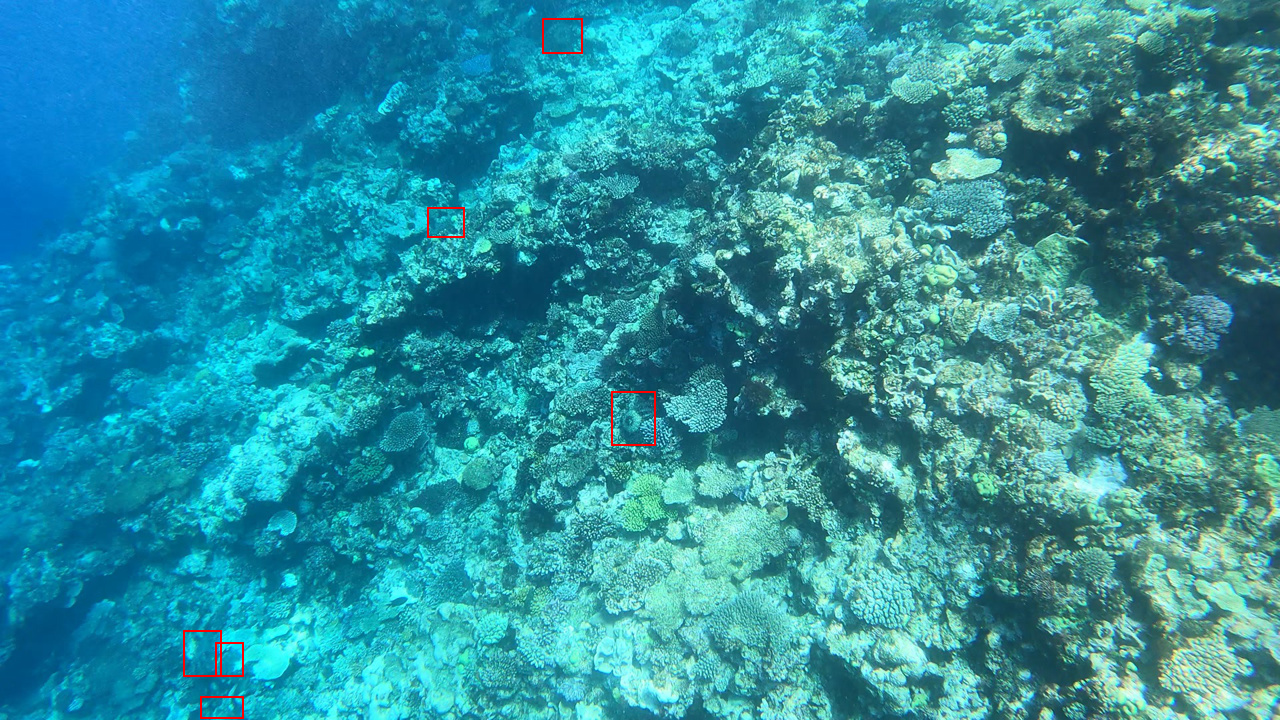

In [430]:
# plot original image

i = 0
img_index = dataset.img_paths.index(paths[i])

img = cv2.imread(paths[i])
orig_labels = dataset.labels[img_index]

plot_image(torch.tensor(img.transpose((2, 0, 1))[::-1].copy()), np.array(orig_labels)[:, 1:])

[      260.5         205          35          30]
[        375        15.5          38          35]


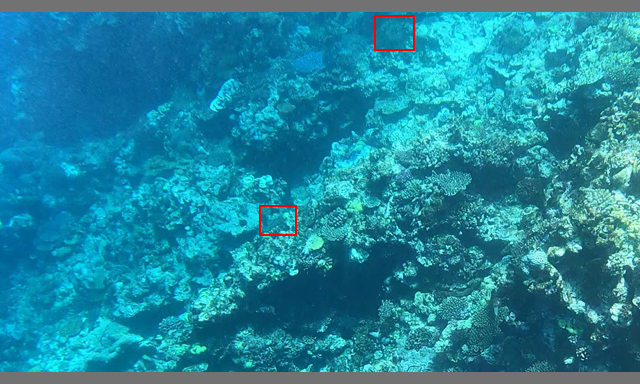

In [431]:
# plot cropped image
img = imgs[i]
cropped_labels = labels[labels[:, 0] == i]

plot_image(img, cropped_labels[:, 2:].numpy())

In [340]:
from reef.yolo.data import Filler

img = imgs[i]
filler = Filler(640, 640)
img, ratio, (dw, dh) = filler.fill(img.numpy().transpose((1, 2, 0)))

img.shape

(384, 640, 3)

In [350]:
img = cv2.imread(dataset.img_paths[0])
filler.fill(img)[2]

(0.0, 12.0)

In [345]:
dataset.img_paths[0]

'/home/isabella/code/competitions/great_barrier_reef/data/splits/s50/images/train/0-16.jpg'

In [ ]:
i = 3
img_index = dataset.img_paths.index(paths[i])
labels = dataset.labels[img_index]
plot_image(imgs[i], labels)

In [223]:
from reef.yolo.data import Slicer

i = 4
path = dataset.img_paths[i]
label = dataset.labels[i]
img = cv2.imread(path)

slicer = Slicer(slice_width=640, slice_height=360, random_state=42)
timg, tlabel, tbox = slicer.slice_random(img, label)
tbox

[102, 348, 742, 708]

In [226]:
for timg, tlabel, tbox in slicer.slice_grid(img, label):
    print(tlabel, tbox)

[[0, 0.86875, 0.6166666666666667, 0.0984375, 0.14166666666666666]] [0, 0, 640, 360]
[] [640, 0, 1280, 360]
[] [0, 360, 640, 720]
[] [640, 360, 1280, 720]


In [225]:
timg, tlabel, tbox = slicer.slice_grid_random(img, label)
tbox

[0, 360, 640, 720]

## Fix labels after padding

In [363]:
from reef.yolo.data import unnormalize

label = [0.5, 0.5, 0.1, 0.1]  # original image label
width = 640  # original image width
height = 360  # original image height
dw = 0.0
dh = 12.0

x, y, w, h = unnormalize(label, width, height)
x = x + dw / 2
y = y + dh / 2

new_width = width + dw
new_height = height + dh

[
    x / new_width,
    y / new_height,
    w / new_width,
    h / new_height
]

[0.5, 0.5, 0.1, 0.0967741935483871]

In [382]:
img = cv2.imread(dataset.img_paths[0])
labels = dataset.labels[0]

filler = Filler(640, 640)
filler.transform(img, labels)[1]

0.0 12.0
584 229 50 32
292.0 114.5
292.0 126.5


[[0, 0.45625, 0.3294270833333333, 0.078125, 0.08333333333333333]]

In [377]:
labels

[[0, 0.45625, 0.31805556, 0.0390625, 0.04444444]]

## Inference

In [2]:
image_size = 640

model_path = "../../modules/yolov5/runs/train/exp27/weights/best.pt"
model = DetectMultiBackend(weights=model_path, device="cpu")
model.warmup(imgsz=(1, 3, image_size, image_size))

12/13/2021 22:51:40 - INFO - utils.general -   Fusing layers... 
12/13/2021 22:51:41 - INFO - utils.general -   Model Summary: 213 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs


In [3]:
image = Image.open("../../data/splits/s50/images/valid/0-11872.jpg")
labels = open("../../data/splits/s50/labels/valid/0-11872.txt").read().rstrip()

In [156]:
from utils.general import non_max_suppression

path = images[1]
image0 = cv2.imread(path.as_posix())
assert image0 is not None, "image not found"

image = preprocess_image(image0, image_size, 32, True)
image = torch.from_numpy(image).float()
image /= 255.0
image = image[None]

preds = model(image)

preds = non_max_suppression(
    preds, 
    conf_thres=0.03, 
    iou_thres=0.45,
    max_det=50
)

gn = torch.tensor(image0.shape)[[1, 0, 1, 0]]


In [170]:
from utils.general import scale_coords, xyxy2xywh

scaled_coords = scale_coords(
    image.shape[2:], 
    torch.tensor(preds[0].numpy()), 
    image0.shape[:2]
)

for *xyxy, conf, cls in reversed(scaled_coords):
    xywh = (xyxy2xywh(torch.tensor(xyxy).view(1, 4)) / gn).view(-1).tolist()
    print(yolo2coco(720, 1280, np.array(xywh)))

[     1021.2      420.24      61.274        61.3]
[     726.56      434.59      55.021      66.454]
[     412.06       136.7      52.851      39.523]
[     306.66      655.89      61.842      62.866]
[     469.82      129.06      42.546      33.808]
[     531.14       121.1      65.332      43.626]
[     1052.8      177.52      60.961      35.179]
